In [1269]:
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, chi2
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor

In [1270]:
train = pd.read_csv('/Users/ziyarat/Desktop/model/train.csv')
test = pd.read_csv('/Users/ziyarat/Desktop/model/test.csv')

submission = pd.read_csv('/Users/ziyarat/Desktop//model/sample_submission.csv')


In [1271]:
# Подготовка данных
# Здесь к двум DataFrame (train и test) добавляется новый столбец под названием dataset, 
# для того, чтобы позже, когда данные будут объединены, можно было легко различать, из какого набора данных (обучающего или тестового) каждая строка.
train['dataset'] = 'train'
test['dataset'] = 'test'

# Объединение DataFrame
combined_df = pd.concat([train, test], ignore_index=True)

In [1272]:
combined_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,dataset
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,train


In [1273]:
# # Строки с пропусками
# missing_counts = combined_df.isnull().sum(axis=1)
# rows_with_missing = combined_df[missing_counts > 15]
# rows_with_missing

In [1274]:
# Удаляем строки, если более 15 колонок NaN	
#cleaned_df = combined_df.dropna(thresh=combined_df.shape[1] - 15)

In [1275]:
# Количественные признаки

# Удаляем признаки из-за большого количества пропусков и невозможномти замены
#  Alley - 2721
#  MasVnrType: Площадь каменного винира в квадратных футах - 1766
#  FireplaceQu Камины: Количество каминов - 1420
#  PoolQC: Качество бассейна - 2909
#  Fence: Качество забора - 2348
#  MiscFeature Разное: Разная функция, не охваченная другими категориями- 2814
combined_df.drop(['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)
# Заменяем на среднее
combined_df['LotFrontage'].fillna(combined_df['LotFrontage'].mean(), inplace=True )
# Колонки количественные с незначительным количеством пропусков заменяем на 0
combined_df[['MasVnrArea', 'BsmtFinSF1','BsmtUnfSF', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtFullBath', 'GarageCars', 'GarageArea', 'GarageYrBlt', 'BsmtHalfBath']] = combined_df[['MasVnrArea', 'BsmtFinSF1','BsmtUnfSF', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtFullBath', 'GarageCars', 'GarageArea', 'GarageYrBlt', 'BsmtHalfBath']].fillna(0)
# Заменяем на медиану
combined_df['SalePrice'].fillna(combined_df['SalePrice'].median(), inplace=True)

# Категориальные признаки

#Удаляем столцы с пропусками характеризующие гараж 
combined_df.drop(['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'], axis=1, inplace=True)	
#Удаляем столцы с пропусками характеризующие подвал
combined_df.drop(['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtQual'], axis=1, inplace=True)
# Удаляем строки с пропущенными значениями, так как их мало
combined_df.dropna(subset=['MSZoning','Exterior1st', 'Exterior2nd', 'Electrical',  'KitchenQual', 'Functional', 'SaleType', 'Utilities'], inplace=True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2909 entries, 0 to 2918
Data columns (total 67 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2909 non-null   int64  
 1   MSSubClass     2909 non-null   int64  
 2   MSZoning       2909 non-null   object 
 3   LotFrontage    2909 non-null   float64
 4   LotArea        2909 non-null   int64  
 5   Street         2909 non-null   object 
 6   LotShape       2909 non-null   object 
 7   LandContour    2909 non-null   object 
 8   Utilities      2909 non-null   object 
 9   LotConfig      2909 non-null   object 
 10  LandSlope      2909 non-null   object 
 11  Neighborhood   2909 non-null   object 
 12  Condition1     2909 non-null   object 
 13  Condition2     2909 non-null   object 
 14  BldgType       2909 non-null   object 
 15  HouseStyle     2909 non-null   object 
 16  OverallQual    2909 non-null   int64  
 17  OverallCond    2909 non-null   int64  
 18  YearBuilt    

In [1276]:
summary_df = pd.DataFrame({
    'NaN_count': combined_df.isna().sum(),
    'data_type': combined_df.dtypes
})
missing_values_df = summary_df[summary_df['NaN_count'] > 0]
missing_values_df

,NaN_count,data_type


In [1277]:
# Разделение DataFrame на train и test
train = combined_df[combined_df['dataset'] == 'train'].drop(columns=['dataset'])
test = combined_df[combined_df['dataset'] == 'test'].drop(columns=['dataset'])

X, y = train.drop('SalePrice', axis=1), train['SalePrice']
# Преобразование целевой переменной
y_log = np.log1p(y)  # log1p(x) = log(1 + x)

X_train, X_valid, y_train, y_valid = train_test_split(X, y_log, test_size=0.2, random_state=42)

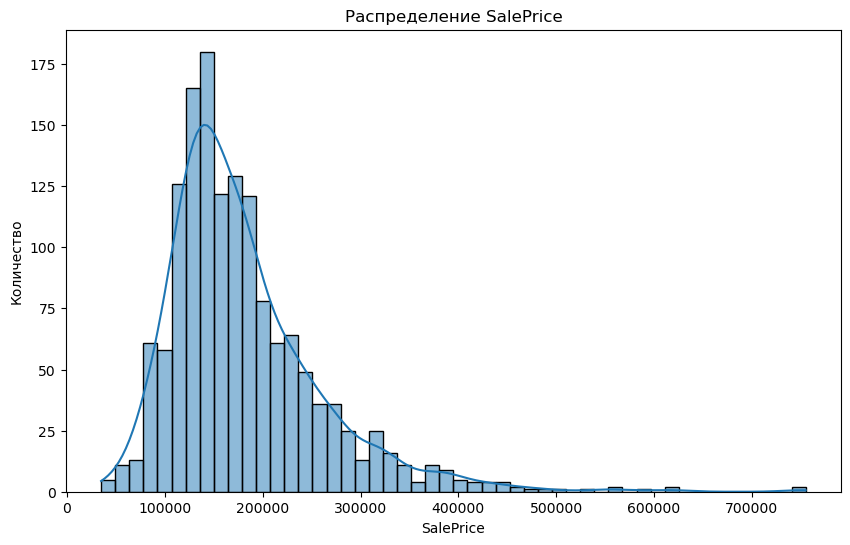

In [1278]:
# Распределение SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(train['SalePrice'], kde=True, bins=50)
plt.title('Распределение SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Количество')
plt.show()

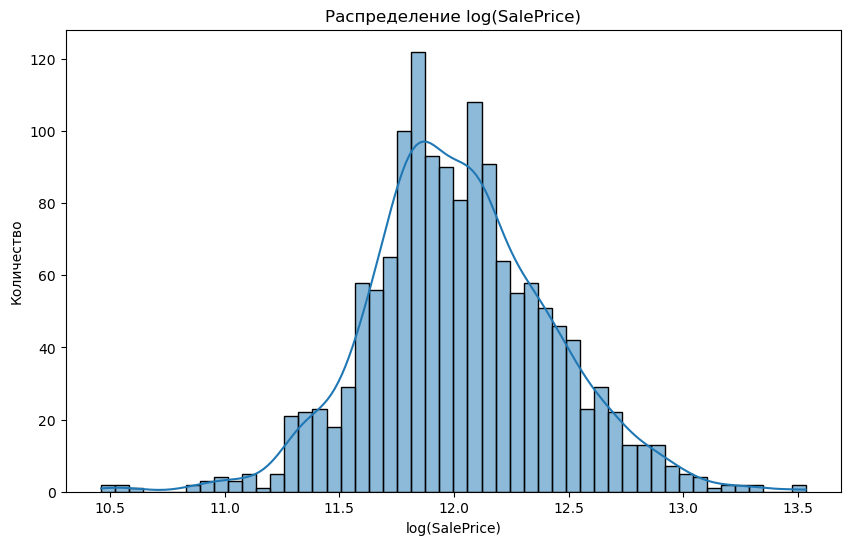

In [1279]:
# Логарифмическое преобразование SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(y_log, kde=True, bins=50)
plt.title('Распределение log(SalePrice)')
plt.xlabel('log(SalePrice)')
plt.ylabel('Количество')
plt.show()

In [1280]:
# Определение категориальных и числовых признаков
# Определение признаков
num_features = X_train.select_dtypes(exclude='object').columns.tolist()  # Имена числовых столбцов
cat_features = X_train.select_dtypes(include='object').columns.tolist()   # Имена категориальных столбцов

In [1281]:
cat_features_one = ['CentralAir']
cat_features.remove('CentralAir')   # Удаляем CentralAir из cat_features
# Нормировка данных
# Создаем ColumnTransformer для обработки числовых и категориальных признаков
drop_features = ['Id']
my_scaler = ColumnTransformer(
    [
        ('drop_features', 'drop', drop_features),
        ('scaling_num_columns', StandardScaler(), num_features),
        ('encoding_cat_columns_onehot', OneHotEncoder(handle_unknown='ignore'), cat_features_one),
        ('encoding_cat_columns_ordinal', TargetEncoder(), cat_features)  
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)  

normalized_array = my_scaler.fit_transform(X_train, y_train)

# processed_df = pd.DataFrame(normalized_array)
# processed_df.head()

In [1282]:
# Модель LinearRegression
from sklearn.linear_model import LinearRegression

ml_pipeline_l = Pipeline(
    [
        ('normalized', my_scaler),
        ('model', LinearRegression())
    ]
)
ml_pipeline_l.fit(X_train, y_train)

Pipeline(steps=[('normalized',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['Id']),
                                                 ('scaling_num_columns',
                                                  StandardScaler(),
                                                  ['Id', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQua...
                                                   'Utilities', 'LotConfig',
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'Heating',
                                                   'HeatingQC', 'Electrical',
                                                   'KitchenQual', 'Functional',
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition'])],
                                   verbose_feature_names_out=False)),
                ('model', LinearRegression())])

In [1283]:
# Прогнозирование на валидационной выборке
y_pred_log = ml_pipeline_l.predict(X_valid)

# # Преобразование предсказаний обратно в оригинальную шкалу
# y_pred = np.expm1(y_pred_log)  # expm1(x) = exp(x) - 1

# Обратное преобразование
y_pred = np.exp(y_pred_log)

In [1284]:
# Оценка качества модели 
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Расчет метрик качеств
mae = mean_absolute_error(np.expm1(y_valid), y_pred)  # Используйте expm1 для y_valid
rmse = np.sqrt(mean_squared_error(np.expm1(y_valid), y_pred))  # Используйте expm1 для y_valid
# Вывод метрик
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 15569.531788255574
RMSE: 21738.571134961385


In [1285]:
# Модель CatBoost
ml_pipeline_c = Pipeline(
    [
        ('normalized', my_scaler),
        ('model', CatBoostRegressor(verbose=0))  # Отключаем вывод
    ]
)
ml_pipeline_c.fit(X_train, y_train)

Pipeline(steps=[('normalized',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['Id']),
                                                 ('scaling_num_columns',
                                                  StandardScaler(),
                                                  ['Id', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQua...
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'Heating',
                                                   'HeatingQC', 'Electrical',
                                                   'KitchenQual', 'Functional',
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x310686120>)])

In [1286]:
# Прогнозирование на валидационной выборке
y_pred_log = ml_pipeline_c.predict(X_valid)

# # Преобразование предсказаний обратно в оригинальную шкалу
# y_pred_с = np.expm1(y_pred_log)  # expm1(x) = exp(x) - 1

# Обратное преобразование
y_pred_c = np.exp(y_pred_log)

In [1288]:
# Расчет метрик качеств
mae = mean_absolute_error(np.expm1(y_valid), y_pred_с)  # Используйте expm1 для y_valid
rmse = np.sqrt(mean_squared_error(np.expm1(y_valid), y_pred_с))  # Используйте expm1 для y_valid
# Вывод метрик
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 13801.258859511341
RMSE: 20007.555122835674


In [1289]:
# Тестовые данные 

In [1290]:
if 'SalePrice' in test.columns:
    y_test_log = np.log1p(test['SalePrice'])
else:
    y_test_log = None

In [1291]:
y_pred_test = ml_pipeline_c.predict(test)

In [1292]:
#y_pred_test = np.expm1(y_pred_test)  # expm1(x) = exp(x) - 1
y_pred_test = np.exp(y_pred_test)

In [1293]:
mae_test = mean_absolute_error(np.expm1(y_test_log), y_pred_test)
rmse_test = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_pred_test))
# Вывод метрик для тестовой выборки
print(f'Test MAE: {mae_test}')
print(f'Test RMSE: {rmse_test}')

Test MAE: 53067.6091413708
Test RMSE: 74539.65415439135


In [1294]:
price = pd.DataFrame({
    'Id': test['Id'].values,
    'SalePrice': y_pred_test
})
price

,Id,SalePrice
0,1461,125663.729833
1,1462,167588.641063
2,1463,184141.910723
3,1464,194505.628567
4,1465,193520.045165
...,...,...
1445,2915,79593.108221
1446,2916,84932.658720
1447,2917,164461.245537
1448,2918,112132.954114


In [1295]:
price.to_csv('price_predictions.csv', index=False)